In [775]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('darkgrid')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 20)

In [776]:
raw_df = pd.read_csv('../shared_datasets/survey_results_public.csv')

### Get dataframe with columns important to us:
- **Respondent**: Randomized respondent ID number (not in order of survey response time)
- **ConvertedComp**: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
- **YearsCode**: Including any education, how many years have you been coding?
- **Age**: What is your age (in years)? If you prefer not to answer, you may leave this question blank.
- **OrgSize**: Approximately how many people are employed by the company or organization you work for?
- **Gender**: Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.
- **Ethnicity**: Which of the following do you identify as? Please check all that apply. If you prefer not to answer, you may leave this question blank.
- **LanguageWorkedWith**: Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
- **Country**: In which country do you currently reside?
- **WorkWeekHrs**: On average, how many hours per week do you work?
- **Extraversion**: Do you prefer online chat or IRL conversations?
- **Dependents**: Do you have any dependents (e.g., children, elders, or others) that you care for?

### Run .py files

In [777]:
%run ../shared_datasets/clean_dataframe.py
%run ../shared_datasets/charlie_functions.py

### Save Cleaned Dataframe as `df`

In [778]:
dataframe_class = CleanDataframe(raw_df)
df = dataframe_class.cleaned_df

### Dropping 'Respondent'

In [779]:
df = df.drop(['Respondent'], axis=1)

### Manipulate/Normalize column names so it can be used to run OLS Regression

In [780]:
subs = [(' ', '_'), ('.', ''), ("’", ""), ("'", ""),
        (';', '_'), ('/', '_'), ('(', ''), (')', ''),
        (':', ''), ('-', '_'), (',', '_'), 
        ('___', '_'), ('__', '_'),
        ('#', 'sharp'), ('+', 'plus'), ('&', 'and')
        ]

def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

### Define the target (outcome) and predictors

In [781]:
outcome = 'ConvertedComp'
x_cols = list(df.columns)
x_cols.remove(outcome)

### Splitting dataframe into Train and Test

In [782]:
train, test = train_test_split(df)
print(len(train), len(test))
# train.head()
# test.head()

13984 4662


### Create function to fit ols model

In [783]:
def fit_ols_model(x_cols, outcome):
    # make df of the model.summary() 
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=train).fit()
    summary = model.summary()
    p_table = summary.tables[1]
    p_table = pd.DataFrame(p_table.data)
    p_table.columns = p_table.iloc[0]
    p_table = p_table.drop(0)
    p_table = p_table.set_index(p_table.columns[0])
    p_table['P>|t|'] = p_table['P>|t|'].astype(float)
    
    x_cols_to_keep = list(p_table[p_table['P>|t|'] < 0.05].index)
    if 'Intercept' in x_cols_to_keep:
#         print("removed Intercept from: fit_ols_model()")
        x_cols_to_keep.remove('Intercept')
#     else:
#         print("skipping... no Intercept found")
        
    x_cols_to_drop = list(p_table[p_table['P>|t|'] > 0.05].index)

    print(f"p_table rows: {len(p_table)} | x_cols_to_keep: {len(x_cols_to_keep)} | x_cols_to_drop: {len(x_cols_to_drop)}")
    print(f"{summary.tables[0].data[0][2].strip()} {summary.tables[0].data[0][3].strip()}")
    print("")
    return summary, x_cols_to_drop, x_cols_to_keep

### Call `fit_ols_model()` to view model

In [784]:
summary, x_drop, x_keep = fit_ols_model(x_cols, outcome)
# summary

p_table rows: 288 | x_cols_to_keep: 131 | x_cols_to_drop: 155
R-squared: 0.628



### Create `while loop` to remove uninfluential features.
- It will remove any features with a p-value less than 0.05

In [785]:
while len(x_drop)>0:
    summary, x_drop, x_keep = fit_ols_model(x_keep, outcome)
    if 'Intercept' in x_drop:
#         print("removed Intercept from: while loop")
        x_drop.remove('Intercept')
#     print(f"{summary.tables[0].data[0][2].strip()} {summary.tables[0].data[0][3].strip()}")
#     print("")
    summary, x_drop, x_keep

p_table rows: 132 | x_cols_to_keep: 113 | x_cols_to_drop: 18
R-squared: 0.622

p_table rows: 114 | x_cols_to_keep: 108 | x_cols_to_drop: 5
R-squared: 0.621

p_table rows: 109 | x_cols_to_keep: 108 | x_cols_to_drop: 0
R-squared: 0.620



### Investigating Multicollinearity

In [786]:
# identify multicollinearity
def investigate_multicollinearity(x_column_keep):
    X = df[x_column_keep]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(f"VIF: {len(vif)} columns compared")
    return list(zip(x_column_keep, vif)), vif, x_column_keep

In [787]:
list_vif, vif, x_keep = investigate_multicollinearity(x_keep)
# list_vif

VIF: 108 columns compared


In [788]:
# Subset features based on multicollinearity
def remove_vif_scores_greater_than_5(x_column_keep, vif):
    vif_scores = list(zip(x_column_keep, vif))
    x_keep = [x for x,vif in vif_scores if vif < 5]
    x_drop = [x for x,vif in vif_scores if vif > 5]
    print(f"Variance Inflation Factor (VIF): {len(vif_scores)} | To Keep: {len(x_keep)} | To Drop: {len(x_drop)}")
    return x_keep, x_drop

In [789]:
x_keep, x_drop = remove_vif_scores_greater_than_5(x_keep, vif)
# while len(x_drop)>0:
#     x_keep, x_drop = remove_vif_scores_greater_than_5(x_keep, vif)

Variance Inflation Factor (VIF): 108 | To Keep: 102 | To Drop: 6


### Checking Model After Dropping Multicollinear Columns

In [746]:
# Refit model with subset features
predictors = '+'.join(x_keep)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     230.9
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:12:22   Log-Likelihood:            -1.6359e+05
No. Observations:               13984   AIC:                         3.274e+05
Df Residuals:                   13884   BIC:                         3.281e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          1.475e+04   2194.627      6.721      0.000    1.04e+04    1.91e+04
WorkWeekHrs                                                                                         295.1695     33.345      8.852      0.000     229.808     360.531
CodeRevHrs                                                                                          257.8942     67.302      3.832      0.000     125.973     389.815
YearsCodePro                                                                                       1695.8968     43.364     39.108      0.000    1610.897    1780.897
learned_code                                                                                       -222.7663     60.352     -3.691      0.000    -341.064    -104.468
Bash_Shell_PowerShell                                                                              1986.6262    524.568      3.787      0.000     958.402    3014.850
Csharp                                                                                            -2805.2159    584.873     -4.796      0.000   -3951.645   -1658.786
Fsharp                                                                                             6390.6847   2275.176      2.809      0.005    1931.033    1.09e+04
Go                                                                                                 6097.8898    861.295      7.080      0.000    4409.635    7786.145
HTML_CSS                                                                                          -4541.8741    561.401     -8.090      0.000   -5642.296   -3441.452
Others                                                                                            -3257.9897    957.815     -3.401      0.001   -5135.437   -1380.542
PHP                                                                                               -6769.0236    649.362    -10.424      0.000   -8041.860   -5496.187
Ruby                                                                                               3369.4895    845.789      3.984      0.000    1711.629    5027.350
Scala                                                                                              7139.1905   1126.321      6.339      0.000    4931.450    9346.931
TypeScript                                                                                         2621.4362    586.000      4.473      0.000    1472.798    3770.075
VBA                                                                                            

### Check Normality Assumption

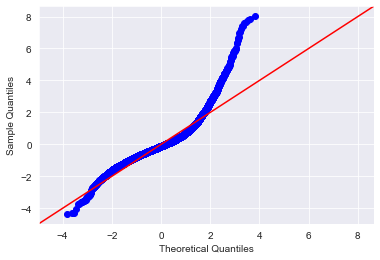

In [747]:
# Check that the residuals are normally distributed
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

### Check Homoscedasticity Assumption

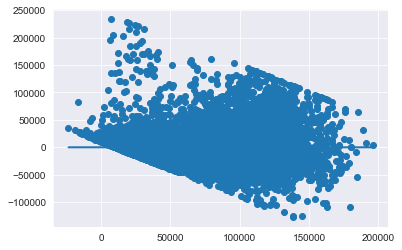

In [748]:
# heck that the residuals are homoscedastic
plt.scatter(model.predict(train[x_keep]), model.resid)
plt.plot(model.predict(train[x_keep]), [0 for i in range(len(train))])

### Additional Refinements To Model

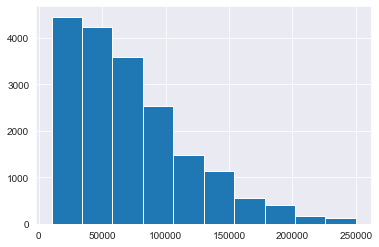

In [749]:
# Check for outliers
df.ConvertedComp.hist()

In [750]:
df.ConvertedComp.sort_values()

50594     10000.0
76849     10000.0
64043     10000.0
49585     10000.0
28701     10019.0
           ...   
80080    250000.0
87930    250000.0
5252     250000.0
16377    250000.0
54013    250000.0
Name: ConvertedComp, Length: 18646, dtype: float64

In [752]:
# Remove extreme outliers
list_first_quartile = []
for i in range(0,20):
    q = i/100
    list_first_quartile.append(df.ConvertedComp.quantile(q=q))
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))
print(f"1st Q: {list_first_quartile[-10]}")
print("")

# Remove extreme outliers
list_fourth_quartile = []
for i in range(80,100):
    q = i/100
    list_fourth_quartile.append(df.ConvertedComp.quantile(q=q))
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))
print(f"4th Q: {list_fourth_quartile[-5]}")

0.0 percentile: 10000.0
0.01 percentile: 10872.0
0.02 percentile: 11520.0
0.03 percentile: 12456.0
0.04 percentile: 13200.0
0.05 percentile: 13993.0
0.06 percentile: 14976.0
0.07 percentile: 16128.0
0.08 percentile: 16884.0
0.09 percentile: 18000.0
0.1 percentile: 19044.0
0.11 percentile: 19998.999999999996
0.12 percentile: 20989.0
0.13 percentile: 21984.0
0.14 percentile: 22944.0
0.15 percentile: 23922.0
0.16 percentile: 25119.200000000004
0.17 percentile: 26157.450000000004
0.18 percentile: 27492.0
0.19 percentile: 28381.400000000012
1st Q: 19044.0

0.8 percentile: 108000.0
0.81 percentile: 110000.0
0.82 percentile: 112277.09999999998
0.83 percentile: 115000.0
0.84 percentile: 119609.99999999997
0.85 percentile: 120000.0
0.86 percentile: 125000.0
0.87 percentile: 127457.79999999999
0.88 percentile: 130000.0
0.89 percentile: 135000.0
0.9 percentile: 140000.0
0.91 percentile: 143000.0
0.92 percentile: 150000.0
0.93 percentile: 150000.0
0.94 percentile: 158600.0
0.95 percentile: 165000.

In [753]:
# Removing Extreme Outliers
orig_tot = len(df)
fourth_quartile = df[df['ConvertedComp'] > list_fourth_quartile[-5]].index
df.drop(fourth_quartile, inplace=True)
# first_quartile = df[df['ConvertedComp'] < list_first_quartile[-1]].index
# df.drop(first_quartile, inplace=True)
print(f'Percent removed: {(orig_tot -len(df))/orig_tot}')
print(f'Rows removed: {(orig_tot -len(df))}')

Percent removed: 0.04816046337015982
Rows removed: 898


### Apply Log Transformation and Re-Run Model

In [754]:
df.ConvertedComp = df.ConvertedComp.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

In [755]:
# Refit model with subset features
predictors = '+'.join(x_keep)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     320.7
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:13:57   Log-Likelihood:                -6040.4
No. Observations:               13311   AIC:                         1.227e+04
Df Residuals:                   13214   BIC:                         1.300e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            10.0869      0.030    339.420      0.000      10.029      10.145
WorkWeekHrs                                                                                           0.0042      0.000      9.217      0.000       0.003       0.005
CodeRevHrs                                                                                            0.0004      0.001      0.407      0.684      -0.001       0.002
YearsCodePro                                                                                          0.0235      0.001     39.187      0.000       0.022       0.025
learned_code                                                                                          0.0003      0.001      0.312      0.755      -0.001       0.002
Bash_Shell_PowerShell                                                                                 0.0355      0.007      5.040      0.000       0.022       0.049
Csharp                                                                                               -0.0165      0.008     -2.094      0.036      -0.032      -0.001
Fsharp                                                                                                0.0664      0.032      2.089      0.037       0.004       0.129
Go                                                                                                    0.0777      0.012      6.710      0.000       0.055       0.100
HTML_CSS                                                                                             -0.0550      0.008     -7.288      0.000      -0.070      -0.040
Others                                                                                               -0.0282      0.013     -2.204      0.028      -0.053      -0.003
PHP                                                                                                  -0.0944      0.009    -10.919      0.000      -0.111      -0.077
Ruby                                                                                                  0.0399      0.011      3.539      0.000       0.018       0.062
Scala                                                                                                 0.1028      0.016      6.615      0.000       0.072       0.133
TypeScript                                                                                            0.0480      0.008      6.138      0.000       0.033       0.063
VBA                                                                                            

In [773]:
p_tablee = model.summary().tables[1]
p_tablee = pd.DataFrame(p_tablee.data)
p_tablee.columns = p_tablee.iloc[0]
p_tablee = p_tablee.drop(0)
p_tablee = p_tablee.set_index(p_tablee.columns[0])
p_tablee['P>|t|'] = p_tablee['P>|t|'].astype(float)
p_tablee

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,10.3127,0.027,376.776,0.000,10.259,10.366
WorkWeekHrs,0.0034,0.000,7.804,0.000,0.003,0.004
CodeRevHrs,0.0013,0.001,1.569,0.117,-0.000,0.003
YearsCodePro,0.0198,0.001,37.692,0.000,0.019,0.021
learned_code,-0.0015,0.001,-2.126,0.033,-0.003,-0.000
...,...,...,...,...,...,...
SOPartFreq_I_have_never_participated_in_QandA_on_Stack_Overflow,-0.0259,0.008,-3.415,0.001,-0.041,-0.011
FizzBuzz_Yes,0.0374,0.008,4.776,0.000,0.022,0.053
Continent_Africa,0.1559,0.030,5.201,0.000,0.097,0.215


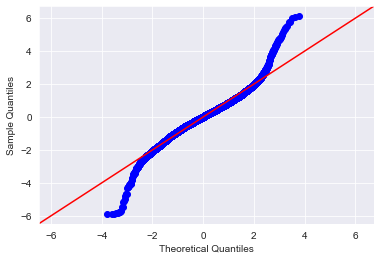

In [756]:
# Check normality assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

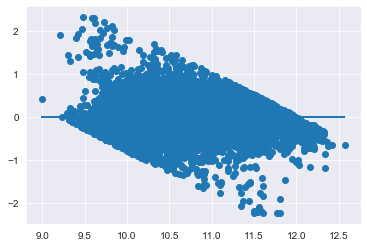

In [757]:
#Check the Homoscedasticity Assumption
plt.scatter(model.predict(train[x_keep]), model.resid)
plt.plot(model.predict(train[x_keep]), [0 for i in range(len(train))])

0.0 percentile: 9.210340371976184
0.01 percentile: 9.290629203204986
0.02 percentile: 9.347664562839402
0.03 percentile: 9.418329675518715
0.04 percentile: 9.48158813796454
0.05 percentile: 9.528939547062684
0.06 percentile: 9.593150789519541
0.07 percentile: 9.662368163875502
0.08 percentile: 9.719778317203755
0.09 percentile: 9.772624555061117
0.1 percentile: 9.817079584856284
0.11 percentile: 9.877658818096801
0.12 percentile: 9.93440465517085
0.13 percentile: 9.967025573340116
0.14 percentile: 10.00946787607336
0.15 percentile: 10.047094261788464
0.16 percentile: 10.087807111992756
0.17 percentile: 10.134599273499514
0.18 percentile: 10.178388290623175
0.19 percentile: 10.221650332241495


9.817079584856284

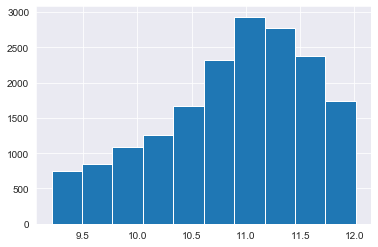

In [758]:
list_first_quartile_log = []
for i in range(0,20):
    q = i/100
    list_first_quartile_log.append(df.ConvertedComp.quantile(q=q))
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))

df.ConvertedComp.hist()
list_first_quartile_log[-10]

0.8 percentile: 11.512925464970229
0.81 percentile: 11.51754477949005
0.82 percentile: 11.543619544870252
0.83 percentile: 11.56171562913966
0.84 percentile: 11.589886506106357
0.85 percentile: 11.608235644774552
0.86 percentile: 11.626254150277232
0.87 percentile: 11.652687407345388
0.88 percentile: 11.678439903447801
0.89 percentile: 11.695247021764185
0.9 percentile: 11.720957378899334
0.91 percentile: 11.736105975397427
0.92 percentile: 11.77528972943772
0.93 percentile: 11.797901554318484
0.94 percentile: 11.825351664784304
0.95 percentile: 11.84939770159144
0.96 percentile: 11.884489021402711
0.97 percentile: 11.918390573078392
0.98 percentile: 11.938193200374572
0.99 percentile: 11.982929094215963


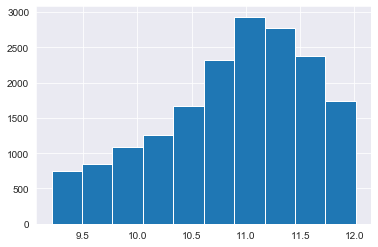

In [759]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))

df.ConvertedComp.hist()

In [760]:
# df = df[df.ConvertedComp <= 11]
log_transformation = df[df['ConvertedComp'] < list_first_quartile_log[-10]].index
df.drop(log_transformation, inplace=True)

train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_keep)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     237.2
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:14:59   Log-Likelihood:                -3426.4
No. Observations:               11979   AIC:                             7049.
Df Residuals:                   11881   BIC:                             7773.
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            10.3127      0.027    376.776      0.000      10.259      10.366
WorkWeekHrs                                                                                           0.0034      0.000      7.804      0.000       0.003       0.004
CodeRevHrs                                                                                            0.0013      0.001      1.569      0.117      -0.000       0.003
YearsCodePro                                                                                          0.0198      0.001     37.692      0.000       0.019       0.021
learned_code                                                                                         -0.0015      0.001     -2.126      0.033      -0.003      -0.000
Bash_Shell_PowerShell                                                                                 0.0258      0.006      4.156      0.000       0.014       0.038
Csharp                                                                                               -0.0219      0.007     -3.117      0.002      -0.036      -0.008
Fsharp                                                                                                0.1032      0.027      3.842      0.000       0.051       0.156
Go                                                                                                    0.0756      0.010      7.345      0.000       0.055       0.096
HTML_CSS                                                                                             -0.0440      0.007     -6.523      0.000      -0.057      -0.031
Others                                                                                               -0.0259      0.011     -2.309      0.021      -0.048      -0.004
PHP                                                                                                  -0.0832      0.008    -10.571      0.000      -0.099      -0.068
Ruby                                                                                                  0.0445      0.010      4.496      0.000       0.025       0.064
Scala                                                                                                 0.0837      0.013      6.272      0.000       0.058       0.110
TypeScript                                                                                            0.0376      0.007      5.378      0.000       0.024       0.051
VBA                                                                                            

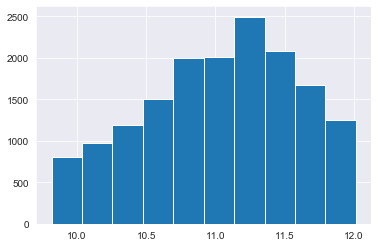

In [761]:
df.ConvertedComp.hist()

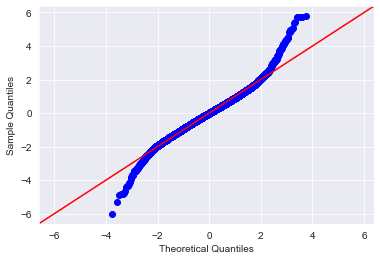

In [762]:
# Check the Normality Assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

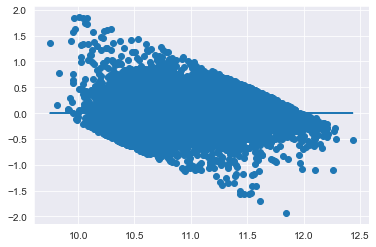

In [763]:
plt.scatter(model.predict(train[x_keep]), model.resid)
plt.plot(model.predict(train[x_keep]), [0 for i in range(len(train))])

In [791]:
len(x_keep)
x_keep

['WorkWeekHrs',
 'CodeRevHrs',
 'learned_code',
 'Bash_Shell_PowerShell',
 'Csharp',
 'Fsharp',
 'Go',
 'HTML_CSS',
 'Others',
 'PHP',
 'Scala',
 'TypeScript',
 'VBA',
 'East_Asian',
 'Native_American_Pacific_Islander_or_Indigenous_Australian',
 'South_Asian',
 'OrgSize_1_000_to_4_999_employees',
 'OrgSize_10_to_19_employees',
 'OrgSize_10_000_or_more_employees',
 'OrgSize_2_9_employees',
 'OrgSize_5_000_to_9_999_employees',
 'Country_Australia',
 'Country_Austria',
 'Country_Bangladesh',
 'Country_Belgium',
 'Country_Canada',
 'Country_Croatia',
 'Country_Denmark',
 'Country_Egypt',
 'Country_Finland',
 'Country_Germany',
 'Country_Greece',
 'Country_Guatemala',
 'Country_Hong_Kong_SAR',
 'Country_Hungary',
 'Country_Iceland',
 'Country_India',
 'Country_Ireland',
 'Country_Israel',
 'Country_Italy',
 'Country_Japan',
 'Country_Kenya',
 'Country_Libyan_Arab_Jamahiriya',
 'Country_Luxembourg',
 'Country_Malaysia',
 'Country_Mexico',
 'Country_Nepal',
 'Country_Netherlands',
 'Country_N

### Playing With Charlie Function

In [ ]:
X = df.drop(columns=['Respondent','ConvertedComp'])
Y = df['ConvertedComp']

sm_performance,sm_variables,sm_outcomes = sm_OLS(X,Y)

# make a deep copy of our X values for the recursive function
X_recursive = pd.DataFrame.copy(X,deep=True)

# recursive_performance,recursive_variables,recursive_outcomes = ols_recursion(X_recursive,Y)

comparison = pd.concat((sm_performance.transpose(),recursive_performance.transpose()),ignore_index=True)
comparison.index = ['294 predictors','118 predictors']
# comparison

# X_recursive

subs = [(' ', '_'), ('.', ''), ("’", ""), ("'", ""),
        (';', '_'), ('/', '_'), ('(', ''), (')', ''),
        (':', ''), ('-', '_'), (',', '_'), 
        ('___', '_'), ('__', '_'),
        ('#', 'sharp'), ('+', 'plus'), ('&', 'and')
        ]

def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

X_recursive.columns = [col_formatting(col) for col in X_recursive.columns]

# list(X_recursive.columns)

x_cols = list(X_recursive.columns)

### Scratch Work

In [ ]:
# generate random data-set
np.random.seed(0)
x = df[['Respondent']]
y = df[['ConvertedComp']]

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# plotting values

# data points
# plt.scatter(x, y, s=10)
# plt.xlabel(x.columns[0])
# plt.ylabel(y.columns[0])

# predicted values
# plt.plot(x, y_predicted, color='r')
# plt.show()

In [ ]:
# scratch work

# df[df['ConvertedComp'] < 2000].sort_values('ConvertedComp', ascending=True)
# df_cleaned[df_cleaned['ConvertedComp'] > 490000].sort_values('ConvertedComp', ascending=True)
# list(df.columns)
# len(list(df.columns))
# corr = df.corr()
# fig, ax = plt.subplots(figsize=(10,10))

# ax = sns.heatmap(
#     corr,
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

# df[df['ConvertedComp'] == 0].sort_values('ConvertedComp', ascending=True)

# cleaned_df = df[['Respondent','ConvertedComp',
#                  'YearsCode','Age','WorkWeekHrs']].dropna()

# df_test = cleaned_df.groupby('Gender')['Respondent'].nunique()
# df_test

# cleaned_df[cleaned_df['ConvertedComp'] >= 1000000].sort_values('Age', ascending=True)
# df_converted_comp = pd.DataFrame(cleaned_df[['Respondent', 'YearsCode', 'Age']])
# troll = df_converted_comp[ (df_converted_comp['YearsCode'] < 10) ].index

# cleaned_df['ConvertedComp'].describe()
# test = cleaned_df.sort_values('Age', ascending=True)[:650]
# test
# cleaned_df[(cleaned_df['Age'] < 18)].sort_values('Age')
# cleaned_df[(cleaned_df['Age'] < 18)].sort_values('Age').describe()
# list_of_unique_countries = cleaned_df['Country'].unique()

# list_of_unique_continent = cleaned_df['Continent'].unique()
# foo = cleaned_df[ cleaned_df['Respondent'] == 1438 ]
# foo = cleaned_df.sort_values('WorkWeekHrs', ascending=False)
# foo
# foo.describe()
# df_test = cleaned_df.groupby('WorkWeekHrs')['Respondent'].nunique()
# df_test
# x = np.random.rand(100, 1)
# y = 2 + 3 * x + np.random.rand(100, 1)
# x = cleaned_df.drop(columns=['ConvertedComp'])
# x = cleaned_df[cleaned_df['calc_age'] > 18]
# y = cleaned_df[(cleaned_df['calc_age'] > 18) & (cleaned_df['ConvertedComp'])]